In [168]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import control
import copy
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.integrate import odeint

### Parameters
$N$ represents the total number of neurons, $p$ represents the connectivity probability, $R$ represents the radius of the spectrum and $\gamma$ represents the ratio between exc. and inh. weights. This matrix satisfies Dale's law

In [229]:
desired_SA = 0.15 #Spectral abscissa
rate = 10 #Rate of learning
N = 200
M = int(N/2) #Number of exc. neurons
p = 0.1
gamma = 3
R = 10

### Colormap for the matrix representation

In [121]:
top = cm.get_cmap('Blues', 128)
bottom = cm.get_cmap('Oranges_r', 128)
newcolors = np.vstack((top(np.linspace(1, 0, 128)),
                       bottom(np.linspace(1, 0, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

### Sparse matrix

In [122]:
def initialnetwork(N,p,R,gamma):
    start_inh = int(N/2)
    NN = round(p*N*(N-1)) #Density without the diagonal 
    fill = np.append(np.ones(NN),np.zeros(N*(N-1)-NN))

    rand_ind = np.random.permutation(N*(N-1))
    fill = np.reshape(fill[rand_ind],(N,N-1)) 
    
    W1 = np.zeros((N,N))
    W1[:N-1,1:] = fill[:N-1,:]
    W2 = np.zeros((N,N))
    W2[1:,:N-1] = fill[1:,:]
    
    W = np.triu(W1,1)+np.tril(W2,-1) #Remove the self-loops    
    w0 = np.sqrt(2)*R/(np.sqrt(p*(1-p)*(1+gamma^2))) #Synaptic strengths
    W = (w0/np.sqrt(N))*W #Excitatory synapses
    W[:,start_inh:] = -gamma*W[:,start_inh:] #Inhibitory synapses
    
    return(W)

Now we need to define the functions that represent the gradient descent algorithm and the lyapunov solver

In [123]:
def soc_function(W_initial,rate,desired_SA,gamma):

    Wsoc = copy.copy(W_initial)
    
    eigenvals,eigenvects = la.eig(Wsoc)
    real_values=np.real(eigenvals)
    e=np.amax(real_values)
    
    #--------------------------------------------------------------------------
    #APPLY THE GRADIENT DESCENT UNTIL THE DESIRED SA IS REACHED
    #-------------------------------------------------------------------------

    while e>desired_SA:
       
        Wsoc = ssa(Wsoc,rate,gamma) #One iteration of gradient descent
        eigenvals,eigenvects = la.eig(Wsoc)
        real_values = np.real(eigenvals)
        e = np.amax(real_values)
        print(e)
        
    return(Wsoc)



def ssa(Wi,rate,gamma):

    #--------------------------------------------------------------------------
    #DEFINITION OF VARIABLES
    #--------------------------------------------------------------------------
   
    N = len(Wi) #Number of neurons in Wi
    start_inh = int(N/2) #Beginning of the inhibition section in W
    eigenvals,eigenvects = la.eig(Wi)
    real_values = np.real(eigenvals)
    Emax = np.amax(real_values) #Maximum real eigenvalue
    
    #--------------------------------------------------------------------------
    #DEFINITION OF LYAPUNOV EQUATIONS
    #--------------------------------------------------------------------------
    
    s = np.amax([1.5*Emax,Emax+0.2])
    A = Wi-(s*np.identity(N))
    X = 2*np.identity(N)
   
    At = A.transpose()
    P = control.lyap(A,X)
    Q = control.lyap(At,X) 
    grad = Q.dot(P)/(np.trace(Q.dot(P))) #Define the gradient 
    
    #--------------------------------------------------------------------------
    #CHANGE W_INH ACCORDING TO THE GRADIENT (ONE ITERATION)
    #--------------------------------------------------------------------------
    
    Wo = copy.copy(Wi)
    Wo[:,start_inh:] = Wi[:,start_inh:]-rate*grad[:,start_inh:]
    
    #--------------------------------------------------------------------------
    #CONSTRAINT 1: POSITIVE INH WEIGHTS ARE NOT ALLOWED
    #--------------------------------------------------------------------------
    
    positive = Wo>0 #Index of positive weights
    positive[:,:start_inh] = False #Don't change the exc weights
    Wo[positive] = 0 #Set the inhibitory ones to zero
    
    #--------------------------------------------------------------------------
    #CONSTRAINT 2: INH WEIGHTS ON AVERAGE ARE GAMMA TIMES STRONGER THAN EXC
    #--------------------------------------------------------------------------
    
    exc_to_exc = Wo[:start_inh,:start_inh]
    exc_to_inh = Wo[start_inh:,:start_inh]    
    inh_to_exc = Wo[:start_inh,start_inh:]
    inh_to_inh = Wo[start_inh:,start_inh:]
    
    meanEE = exc_to_exc.mean()
    meanEI = exc_to_inh.mean()
    meanIE = inh_to_exc.mean()
    meanII = inh_to_inh.mean()

    Wo[:start_inh,start_inh:] = -gamma*(meanEE/meanIE)*Wo[:start_inh,start_inh:]
    Wo[start_inh:,start_inh:] = -gamma*(meanEI/meanII)*Wo[start_inh:,start_inh:]
    
    #--------------------------------------------------------------------------
    #CONSTRAINT 3: INH WEIGHTS ON AVERAGE ARE GAMMA TIMES STRONGER THAN EXC
    #--------------------------------------------------------------------------
    
    inh_weights = Wo[:,start_inh:]
    inh_weights = np.ravel(inh_weights)
    ind_sort = np.argsort(inh_weights) #Ascendent order (more neg to less neg)
    threshold = round(0.4*len(inh_weights))
    inh_weights[ind_sort[threshold:]] = 0
    Wo[:,start_inh:] = np.reshape(inh_weights,(N,start_inh))
    
    #--------------------------------------------------------------------------
    #CONSTRAINT 4: REMOVE ANY SELF LOOPS
    #--------------------------------------------------------------------------
    
    Wo = Wo-np.diag(np.diag(Wo))
    
    return (Wo)

### Define the dynamics for $g = 1$

In [212]:
gains = np.ones((N,1)) #Inititalize gains 

params = {
    'n_time' : 400,
    'over_tau' : 1/200,
    't_f' : 1000,
    'r0' : 20,
    'rmax' : 100,
    'gains' : np.transpose([gains[:,0]])
    }

def f_NL(x):
    x = x.reshape(N,1) #Reshape the squeezed vector 
    out = np.zeros(np.shape(x)) #Output vector
    
    r0 = params['r0']
    rmax = params['rmax']
    g = params['gains']
    
    negative = x<0 #Find the negative index for activity    
    out[negative] = r0*np.tanh(g[negative]*x[negative]/r0)
    
    positive = ~negative 
    out[positive] = (rmax-r0)*np.tanh(g[positive]*x[positive]/(rmax-r0))
    
    return np.squeeze(out)

#----------------------------------------------------------------
#NEURONAL DYNAMICS
#----------------------------------------------------------------

def dynamics(x,t,W):
  
    dxdt = params['over_tau']*(-x + W.dot(f_NL(x)))
    
    return np.squeeze(dxdt)

def run_dynamics(W, current_gains, params, x_initial):
   
    params['gains'] = current_gains #Update the gains
    time = np.linspace(0,params['t_f'],params['n_time'])
    
    X = odeint(dynamics, np.squeeze(x_initial), time, args=(W,))
    R = final_f_NL(X)
    
    sol = {
        't' : time,
        'R' : R
        }
    return sol

def final_f_NL(X):
   
    G = np.tile(np.transpose(params['gains']),(params['n_time'],1))
    R = np.zeros(np.shape(X))
        
    r0 = params['r0']
    rmax = params['rmax']
        
    negative = X<0    
    R[negative] = r0*np.tanh(G[negative]*X[negative]/r0)
        
    positive = ~negative 
    R[positive] = (rmax-r0)*np.tanh(G[positive]*X[positive]/(rmax-r0))
         
    return R   

### Compute matrix spectrum

In [124]:
def compute_spect(W):
    eigval,eigvec = la.eig(W)
    r_spect = np.real(eigval)
    i_spect = np.imag(eigval)
    
    return r_spect, i_spect

### Compute the initial condition that amplifies the neuronal activity for a given Matrix

In [171]:
def x_initial(W):
    A = W-np.identity(N)
    X = 2*np.identity(N)

    At = A.transpose()
    Q = control.lyap(At,X)

    Q_eigenval,Q_eigenv = la.eig(Q)

    #Pick the largest eigenvector
    pos_max = np.argmax(Q_eigenval)
    v = [Q_eigenv[:,pos_max]] #normalized already
    alpha = 1.5*np.sqrt(N)
    x_initial = alpha*np.transpose(v)
    
    return x_initial

### Intensify the connections for a rank-2 loop 

In [307]:
def increase_loop_rank2(W,init_out, end_out, init_in, end_in, beta):
    W_new = copy.copy(W) #Modified SOC
    pos_in, pos_out = [],[]
    for i in range(init_out,end_out):
        for j in range(init_in,end_in):
            if W[j,i] != 0 and W[i,j] != 0:
                W_new[i,j] = beta*W[i,j] 
    index_loop = np.where(np.abs(Wsoc - W_new) > 0 )
    return W_new, index_loop

# Experiment
Generate an initial matrix $W_{i}$, compute its spectrum and find the associated $W_{soc}$

In [151]:
Wi = initialnetwork(N,p,R,gamma) #Generate Dale's matrix

<ipython-input-343-09d1511dcae6>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


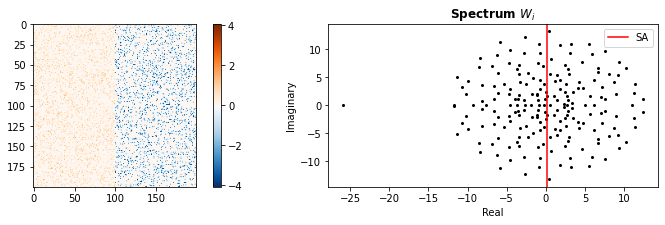

In [343]:
w_max = np.abs(Wi).max() #Max values to range colorplot

spect_init = compute_spect(Wi) #Computes its spectrum

#Plots
fig, (ax0, ax1) = plt.subplots(figsize = (13,3), ncols = 2)
pos = ax0.imshow(Wi, cmap=newcmp, vmin=-w_max, vmax=w_max)
fig.colorbar(pos, ax=ax0)

ax1.scatter(spect_init[0],spect_init[1],c= 'k', s = 4)
ax1.axvline(x = desired_SA, color = 'r', label = 'SA')
ax1.legend()
ax1.set_title('Spectrum $W_{i}$', fontweight ="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginary')
fig.show()

In [153]:
Wsoc = soc_function(Wi,rate,desired_SA,gamma)

12.346635267848605
11.806730854429464
11.390987991876692
11.060137017532828
10.782478307450887
10.524283780158349
10.298465915502504
10.087733414544264
9.890440102343096
9.701796164620689
9.521334987712738
9.348142894615197
9.180966051226273
9.019159148102336
8.863882820517592
8.713229050304543
8.566885283792917
8.42448431108894
8.285806660880024
8.149311200788206
8.036654203260209
7.936899858089815
7.842387836255541
7.752604507230256
7.66676882718607
7.584528199017594
7.505230918889758
7.428139031184515
7.35323245913361
7.279485352149519
7.207003590712672
7.136009294647325
7.066259144991134
6.997144992924232
6.9288140397486835
6.861582153970353
6.794083538768107
6.727760039225847
6.662773979114634
6.598263014689882
6.534240289463733
6.470799871683407
6.408354686780216
6.346527985474397
6.285227549389058
6.224773215183583
6.1655391981585685
6.10804115153205
6.0511402311710585
5.99433972714013
5.93844371889286
5.883111581455115
5.828793245248642
5.774639266816184
5.722524430932783
5.670

0.698260566072526
0.6953871506096219
0.692459962216633
0.6896845982022957
0.6867794811686071
0.683683709564679
0.6806840396354001
0.6777338151297043
0.6747103371953904
0.6717430893313778
0.6688637457487299
0.6659743031408181
0.6631697705706947
0.660381795018079
0.6575813523315959
0.6547926913841451
0.6520257151964648
0.6492348151987909
0.6464437919337224
0.6436853905604076
0.6407321476068044
0.6378860395780481
0.6350694826450483
0.6322271259112338
0.6294482833944157
0.6267066196730888
0.6239186099260534
0.6211595826829822
0.6184008020110099
0.615677962037712
0.6130496154476638
0.6103603065539258
0.6076630128388141
0.6050482469747789
0.6024229712209732
0.5998474202133419
0.5972855942328339
0.5947799750171132
0.5921802681327084
0.5896924875408707
0.5872265650721626
0.5846937843928579
0.5821760916232424
0.5796495193004085
0.5771899472231883
0.5746989389348411
0.5721622355494893
0.569702304645356
0.5672191292295561
0.5647696741866102
0.5622925844199784
0.5598477047744679
0.5573247517828464

0.2757033906709433
0.27560293118539647
0.2753765168857132
0.2752239082828374
0.2750651725400073
0.27490618366834285
0.27474689330775437
0.2745798385118454
0.2744088391225863
0.27423891055878635
0.27406985112102333
0.27390151884204483
0.2737338322248237
0.27356314901988954
0.2734047471053609
0.27324795928069845
0.27311054425167125
0.2729608479625245
0.2728063014801845
0.2726485444496176
0.2724582073704207
0.2722721724999597
0.2720918267960639
0.2718742498639566
0.2716734495107693
0.2714804007272489
0.2712777427829731
0.27109135316263777
0.2709373985319994
0.270782211226285
0.2706296859768107
0.27046922184708644
0.27034810439376367
0.27018094819002525
0.2700143788785374
0.26984729850974776
0.26968025781110816
0.2695136305691609
0.2693476716603146
0.2691454319981411
0.26898494734215384
0.2688060720194694
0.26864555578870797
0.2684903514342306
0.26833451353273324
0.26816417160577777
0.26801754444214687
0.2678920010312559
0.26777597265177255
0.26764764783787137
0.2675142667435911
0.26737721

0.2289732194599815
0.22890154502686128
0.22883160897039545
0.22876292193602632
0.2286791597172017
0.22864362872938754
0.2286018778163489
0.22855574562374326
0.22850647167861904
0.2284533485263266
0.22839694148577605
0.22833492176742132
0.22825263419743896
0.22820505353610177
0.22813884641958737
0.22808934439665562
0.22801327181231068
0.22793876133764257
0.22786650236508876
0.2277953472214258
0.22772478281593778
0.2276240701519887
0.22755681135949812
0.22749234316543598
0.22742303190908153
0.22734772785303647
0.22727399030405082
0.22724153764092625
0.22720202639831744
0.22715621613020487
0.22707739921620274
0.2270314814559793
0.2270167922042341
0.22694351758381925
0.22686729576994047
0.22680154345135772
0.22675217315646146
0.2266985700659887
0.2266419853210475
0.22659782566299747
0.2265442983478203
0.2265054712527821
0.22644313785958614
0.226379881787086
0.22631663319620499
0.22626108298741254
0.22620339589567928
0.22614987256623165
0.22609541221901153
0.22603837256666637
0.225977197481

0.2064364395541325
0.20638062175633554
0.20632596330578745
0.2062721659620732
0.2062406297185042
0.2061817496646947
0.20612456669447177
0.20607699128661094
0.2060240556993831
0.20596238499228292
0.20591451509620629
0.20587313676825603
0.20582409549639213
0.20577465539608286
0.20572476681697816
0.2056782572015099
0.20563122524938615
0.2055836752854605
0.20553562722059837
0.20548712162555427
0.20543820762396892
0.20538137412480317
0.20534221621652882
0.20529920499107068
0.20524939031706646
0.20519857072614833
0.2051509304104071
0.20509543027758603
0.20504686219762402
0.20500298336927103
0.2049380912238934
0.2048751746977373
0.20481403031110967
0.2047537855036925
0.20469709448024276
0.20463930869962077
0.2045873389514199
0.20453617470705943
0.20448551160168038
0.20441910199768287
0.2043575975948535
0.204298814855851
0.20424484002158927
0.20418659476350431
0.20413052911678364
0.20407606540933487
0.20402122977893977
0.2039653240229366
0.20391030811931016
0.20385602645164974
0.20380680638360

0.1889685220876003
0.18895330596831017
0.18893778172675035
0.1889218760485214
0.18890555800317022
0.18888882287691744
0.18887168126104115
0.18885546501738948
0.18883813878494915
0.1888200278428318
0.1888014366115116
0.18878248188272084
0.18876366267973066
0.18873999460839963
0.1887102796558413
0.18869456849750255
0.1886771697937053
0.1886563836615105
0.18863814146979663
0.18861956423493909
0.18860063973133268
0.1885814118024436
0.18856191312868664
0.18854216877731877
0.18852504476486343
0.1885228181606715
0.18849575573207145
0.18846852555028915
0.18844141537789527
0.18841355681122818
0.18838734067280827
0.18835554159010037
0.18833322915982653
0.18831098132064628
0.18828750131485938
0.18826335665199512
0.18823989678868713
0.18821397496340386
0.1881825683337156
0.18816578369900072
0.1881467646414725
0.18812627379844676
0.1880861018923239
0.18805615644176688
0.1880293533228392
0.18799676640502305
0.18796836318406157
0.1879508505015124
0.1879329935634524
0.1879231575789595
0.18789719983664

0.17991621132117142
0.17990706733606565
0.17987837933048012
0.17985665443951787
0.17983514232029926
0.17981374262715644
0.1797923979988285
0.1797710796247669
0.17975136346212317
0.17973043372595576
0.1797097363297988
0.17970405626700492
0.17968893111385287
0.17967275771546065
0.17965571643435085
0.17963796554346367
0.17961963173421713
0.17960081653668736
0.17958160143630053
0.17957222925675342
0.17954879310975702
0.17952824766284547
0.17950094274407147
0.1794742576312931
0.1794482307275691
0.1794228236502602
0.1793998857080621
0.1793567740566122
0.17932525717174363
0.17929720242012914
0.17927141534737046
0.17924710265556376
0.1792237365868598
0.17920096741580416
0.17917910363084677
0.1791563338802742
0.17913416269209126
0.17911222480744815
0.17909031478185783
0.17906833149663082
0.179046232823467
0.1790352613706827
0.17901888851907083
0.17900114492136154
0.17898236443485782
0.17896278912264574
0.1789276002912823
0.17890951223691287
0.17889085369965363
0.17887172703196175
0.178850418721

0.18079762781152398
0.1807703394216611
0.18074316556997694
0.18071602450164703
0.1806785195264748
0.18065329741664216
0.18062731502775886
0.18060060481883933
0.18057320106572594
0.18054517297832717
0.18051660031721384
0.1804875607850685
0.18045812270259787
0.1804283438330796
0.1803982716186019
0.18036794387871558
0.18033739014165917
0.1803066331564645
0.1802756901884377
0.18024457420382878
0.18021329516601092
0.18018124588014373
0.18014934263512705
0.1801177128312141
0.1800861771850054
0.18005462734932254
0.18002299444943226
0.17999123520400473
0.17995932280088667
0.17992724116087655
0.17989498139452642
0.17986253917830194
0.17982991316541064
0.1797971039621551
0.17976411344014775
0.1797309442536067
0.17969759943729424
0.1796640821681419
0.17963039580886475
0.17959654377801737
0.17956252930645278
0.17952835548226997
0.17949402524185776
0.17947481631737316
0.17945996787078955
0.17943761805150538
0.17941390718951888
0.17938898663914915
0.17936299081586893
0.17933603757162597
0.1793082310

0.16658582688649348
0.1665928097344327
0.16659983836277337
0.16660692642243413
0.16661970600963838
0.1666309051505901
0.1666409970278795
0.16665036960397472
0.16665924040022673
0.1666628784833828
0.1666729730714991
0.1666828939813607
0.16669272386630984
0.1667024690202863
0.16670803276523816
0.16671627110243414
0.16672498305184114
0.1667337212431772
0.16674344763423887
0.1667539086697245
0.166764849611585
0.16676679375013848
0.16678267781362943
0.1667974466775739
0.1668113179135582
0.16682442170881862
0.16683687739939534
0.16684879032146904
0.16686025093989731
0.16687133579982394
0.16688210917936153
0.16689262487718692
0.1669029279005021
0.16691305589148975
0.16692304028483562
0.16693290749009893
0.1669426796904283
0.16693429144671712
0.1669262913253311
0.16692306299534776
0.16692138413536295
0.1669209348719094
0.1669214517806843
0.16692275573752058
0.16692471837713074
0.16692724447699292
0.16693026068202332
0.16693894106795892
0.16694645240947548
0.16695429628525593
0.1669623383586769

0.16897993846736445
0.16898508016088834
0.1689901521671357
0.16899513065517202
0.16900203038648165
0.1690094982599519
0.16901674228960184
0.1690237693427753
0.16903051381903333
0.16903692459995567
0.16904296645424766
0.1690486187298934
0.16905387202457156
0.16905872553004353
0.1690631846628996
0.16906725903327313
0.1690709608394284
0.16907430375393884
0.16908368944172403
0.16909195978158675
0.1690979276283382
0.16908452252757122
0.16907865728994131
0.1690728703110107
0.1690682962872061
0.16908456963041196
0.16907399393061695
0.1690661086014562
0.16906011552417818
0.1690554256210226
0.16905164011676477
0.16907609316243688
0.1690818783695307
0.16908553134156268
0.16908751197717575
0.1690881537176292
0.16908773394363627
0.16908647578311364
0.16908455530195668
0.16908210980556615
0.16907924547378972
0.16907604405619547
0.1690725682923584
0.169068866037567
0.16906497375426166
0.16906091909886278
0.16904503171135987
0.16902829399699182
0.16901457186188668
0.16900360927411529
0.16900380877325

0.16245245837413297
0.16242591002778278
0.16239494892356554
0.16237156211959772
0.16234670379236474
0.16232106276355163
0.16229499301405823
0.162268703935073
0.16224231826392407
0.162215906525355
0.1621972853341038
0.1621769769635968
0.16216817622504065
0.1621584301430392
0.1621464850307528
0.16212939026658543
0.16211191168741262
0.16209620905683983
0.16207685377747438
0.16205694366056772
0.1620365001325164
0.1620155087418187
0.1619939886242805
0.16197197530485896
0.16194961771183225
0.16193110637986097
0.161911788752019
0.1618916916253968
0.1618708855610329
0.161849438675346
0.16182729296931053
0.16180821703793719
0.16178872555190393
0.1617585416003372
0.16172245978624789
0.16169384442808665
0.1616665345654208
0.16164030861827017
0.1616148623853002
0.16158996709883933
0.1615654512584307
0.16154118653401262
0.1615170770854173
0.16149305159275373
0.16150716452225167
0.16147262615281222
0.16143978586471897
0.16140846422720723
0.16137831666050373
0.1613490782124173
0.16132054425746956
0.1

0.15023866528295926
0.15020406523252336
0.150169198336302
0.15013411806396437
0.1500988640698288
0.15006346613417265
0.15002794762217136
0.14998560697762497


<ipython-input-342-5cda2910c933>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


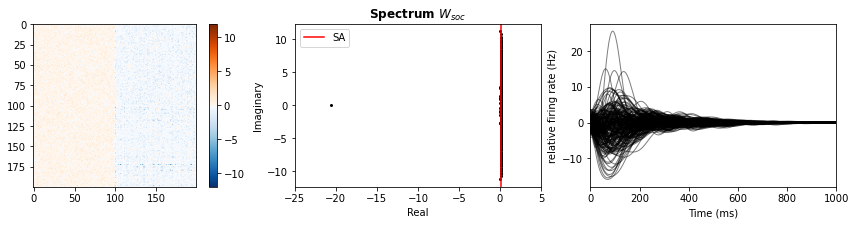

In [342]:
x0 = x_initial(Wsoc) #Find the initial condition that ampifies the dynamics

spect_soc = compute_spect(Wsoc)
wsoc_max = np.abs(Wsoc).max() #Max values to range colorplot

g = np.ones((N,1))
activity = run_dynamics(Wsoc, g , params, x0)

#Plots
fig, (ax0, ax1, ax2) = plt.subplots(figsize = (15,3), ncols = 3)
pos = ax0.imshow(Wsoc, cmap=newcmp, vmin=-wsoc_max, vmax=wsoc_max)
fig.colorbar(pos, ax=ax0)
ax1.scatter(spect_soc[0],spect_soc[1],c= 'k', s = 4)
ax1.set_title('Spectrum $W_{soc}$', fontweight ="bold")
ax1.axvline(x = desired_SA, color = 'r', label = 'SA')
ax1.legend()
ax1.set_xlim([-25,5])
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginary')
ax2.plot(activity['t'],activity['R'], color = 'k', alpha = 0.5,  linewidth = 1)
ax2.set_xlim([0,params['t_f']])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('relative firing rate (Hz)')
fig.show()

### Look for rank-2 loops in $W_{soc}^{++}$
<br>
We start looking for closed loops in $W_{soc}^{++}$. For neuron $i^{\text{th}}$ we look for neurons $j^{\text{th}}$ st. $w_{ji},w_{ij} \neq 0$

<ipython-input-301-88683498af80>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


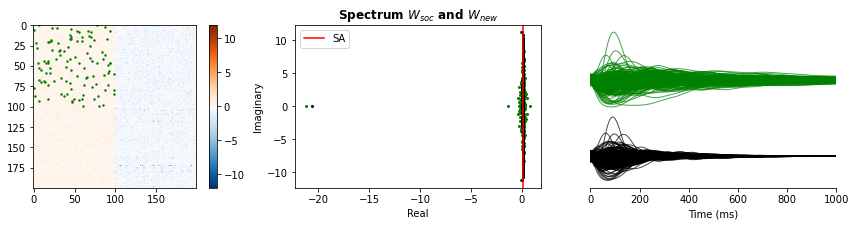

In [301]:
W_new, index_loop = increase_loop_rank2(Wsoc, 0, M, 0, M, 1.5)
spect_new = compute_spect(W_new) #New spectrum 
activity_new = run_dynamics(W_new, g , params, x0)

#Plots
fig, (ax0, ax1,ax2) = plt.subplots(figsize = (15,3), ncols = 3)
pos = ax0.imshow(Wsoc, cmap=newcmp, vmin=-wsoc_max, vmax=wsoc_max)
ax0.scatter(index_loop[0],index_loop[1], color = 'g', s = 2)
fig.colorbar(pos, ax=ax0)            
ax1.scatter(spect_new[0],spect_new[1],c= 'g',  s = 4)
ax1.scatter(spect_soc[0],spect_soc[1],c= 'k',  s = 4)
ax1.axvline(x = desired_SA, color = 'r', label = 'SA')
ax1.legend()
ax1.set_title('Spectrum $W_{soc}$ and $W_{new}$', fontweight ="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginary')
ax2.plot(activity['t'],activity['R'], color = 'k', alpha = 0.7,  linewidth = 1)
ax2.plot(activity_new['t'],activity_new['R'] + 50 , color = 'g', alpha = 0.7,  linewidth = 1)
ax2.set_xlim([0,params['t_f']])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('relative firing rate (Hz)')
ax2.axes.get_yaxis().set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
fig.show()            

### Look for rank-2 loops in $W_{soc}^{-+}$
<br>
We look for closed loops in $W_{soc}^{-+}$. For neuron $i^{\text{th}}$ we look for neurons $j^{\text{th}}$ st. $w_{ji},w_{ij} \neq 0$

<ipython-input-327-1ad9578dd0c2>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


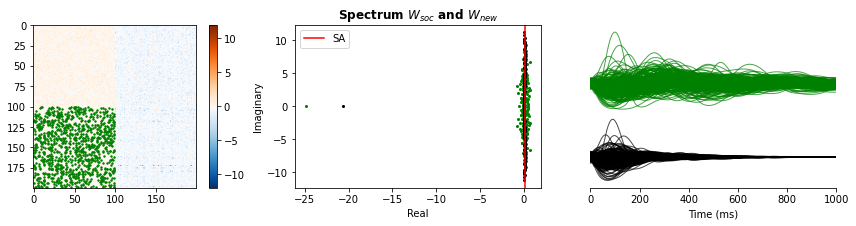

In [327]:
W_new, index_loop = increase_loop_rank2(Wsoc, 0, M, M, N, 0.7)
spect_new = compute_spect(W_new) #New spectrum 
activity_new = run_dynamics(W_new, g , params, x0)

#Plots
fig, (ax0, ax1,ax2) = plt.subplots(figsize = (15,3), ncols = 3)
pos = ax0.imshow(Wsoc, cmap=newcmp, vmin=-wsoc_max, vmax=wsoc_max)
ax0.scatter(index_loop[0],index_loop[1], color = 'g', s = 2)
fig.colorbar(pos, ax=ax0)            
ax1.scatter(spect_new[0],spect_new[1],c= 'g',  s = 4)
ax1.scatter(spect_soc[0],spect_soc[1],c= 'k',  s = 4)
ax1.axvline(x = desired_SA, color = 'r', label = 'SA')
ax1.legend()
ax1.set_title('Spectrum $W_{soc}$ and $W_{new}$', fontweight ="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginary')
ax2.plot(activity['t'],activity['R'], color = 'k', alpha = 0.7,  linewidth = 1)
ax2.plot(activity_new['t'],activity_new['R'] + 50 , color = 'g', alpha = 0.7,  linewidth = 1)
ax2.set_xlim([0,params['t_f']])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('relative firing rate (Hz)')
ax2.axes.get_yaxis().set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
fig.show()            

### Look for rank-2 loops in $W_{soc}^{+-}$
<br>
We look for closed loops in $W_{soc}^{+-}$. For neuron $i^{\text{th}}$ we look for neurons $j^{\text{th}}$ st. $w_{ji},w_{ij} \neq 0$

<ipython-input-325-d2b99e21e52c>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


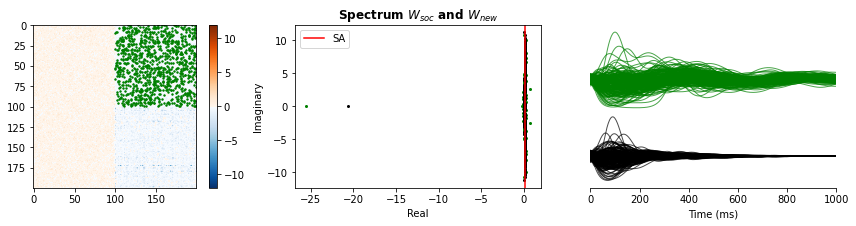

In [325]:
W_new, index_loop = increase_loop_rank2(Wsoc, M, N, 0, M, 0.8)
spect_new = compute_spect(W_new) #New spectrum 
activity_new = run_dynamics(W_new, g , params, x0)

#Plots
fig, (ax0, ax1,ax2) = plt.subplots(figsize = (15,3), ncols = 3)
pos = ax0.imshow(Wsoc, cmap=newcmp, vmin=-wsoc_max, vmax=wsoc_max)
ax0.scatter(index_loop[0],index_loop[1], color = 'g', s = 2)
fig.colorbar(pos, ax=ax0)            
ax1.scatter(spect_new[0],spect_new[1],c= 'g',  s = 4)
ax1.scatter(spect_soc[0],spect_soc[1],c= 'k',  s = 4)
ax1.axvline(x = desired_SA, color = 'r', label = 'SA')
ax1.legend()
ax1.set_title('Spectrum $W_{soc}$ and $W_{new}$', fontweight ="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginary')
ax2.plot(activity['t'],activity['R'], color = 'k', alpha = 0.7,  linewidth = 1)
ax2.plot(activity_new['t'],activity_new['R'] + 50 , color = 'g', alpha = 0.7,  linewidth = 1)
ax2.set_xlim([0,params['t_f']])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('relative firing rate (Hz)')
ax2.axes.get_yaxis().set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
fig.show()   

### Look for rank-2 loops in $W_{soc}^{--}$
<br>
We look for closed loops in $W_{soc}^{--}$. For neuron $i^{\text{th}}$ we look for neurons $j^{\text{th}}$ st. $w_{ji},w_{ij} \neq 0$

<ipython-input-339-91d3ff5e8a23>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


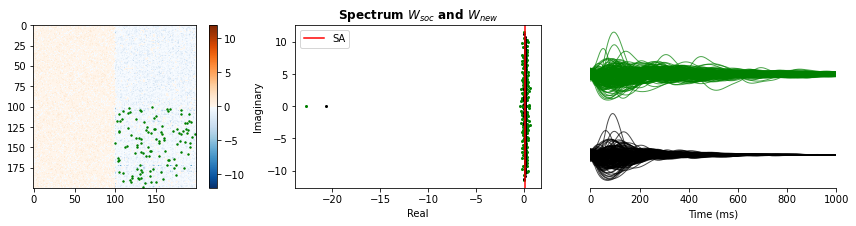

In [339]:
W_new, index_loop = increase_loop_rank2(Wsoc, M, N, M, N, 3)
spect_new = compute_spect(W_new) #New spectrum 
activity_new = run_dynamics(W_new, g , params, x0)

#Plots
fig, (ax0, ax1,ax2) = plt.subplots(figsize = (15,3), ncols = 3)
pos = ax0.imshow(Wsoc, cmap=newcmp, vmin=-wsoc_max, vmax=wsoc_max)
ax0.scatter(index_loop[0],index_loop[1], color = 'g', s = 2)
fig.colorbar(pos, ax=ax0)            
ax1.scatter(spect_new[0],spect_new[1],c= 'g',  s = 4)
ax1.scatter(spect_soc[0],spect_soc[1],c= 'k',  s = 4)
ax1.axvline(x = desired_SA, color = 'r', label = 'SA')
ax1.legend()
ax1.set_title('Spectrum $W_{soc}$ and $W_{new}$', fontweight ="bold")
ax1.set_xlabel('Real')
ax1.set_ylabel('Imaginary')
ax2.plot(activity['t'],activity['R'], color = 'k', alpha = 0.7,  linewidth = 1)
ax2.plot(activity_new['t'],activity_new['R'] + 50 , color = 'g', alpha = 0.7,  linewidth = 1)
ax2.set_xlim([0,params['t_f']])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('relative firing rate (Hz)')
ax2.axes.get_yaxis().set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
fig.show()   

In [206]:
with open('spectral_analysis.npy', 'wb') as f:
    np.save(f,Wsoc)
    np.save(f,x0)